In [1]:
%matplotlib inline

import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_regularization
from gaminet.utils import plot_trajectory

In [2]:
def load_fico(path="./", missing_strategy="drop"):
    data = pd.read_csv(path + "/fico/heloc_dataset_v1.csv")
    meta_info = json.load(open(path + "/fico/data_types.json"))
    meta_info.pop("RiskPerformance")

    ## remove samples with all the values == -9
    rem_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) == 23)[0]
    keep_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) < 23)[0]
    data_rem9 = data.iloc[keep_sample_idx]

    ## dummy for -7, -8, -9
    sample_size = data_rem9.shape[0]
    dummy_data = pd.DataFrame(index = data_rem9.index)
    for i in np.where(np.sum(data_rem9 == -9, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -9)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-9"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-9":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -8, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -8)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-8"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-8":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -7, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -7)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-7"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-7":{"type": "categorical"}})

    meta_info.update({"RiskPerformance":{"type": "target"}})
    final_data = pd.concat([data_rem9.replace(-9, 0).replace(-8, 0).replace(-7, 0), dummy_data], 1)
    x, y = final_data.iloc[:,1:].values, final_data.iloc[:,[0]].values
    return x, y, "Classification", meta_info

def load_classification_data(name):
    data_path = '.'
    func_dict = {'fico':load_fico}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_(data_path, missing_strategy="impute")
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                enc = OrdinalEncoder()
                enc.fit(y)
                y = enc.transform(y)
                meta_info[key]['values'] = enc.categories_[0].tolist()
            elif item['type'] == 'categorical':
                enc = OrdinalEncoder()
                xx[:,[i]] = enc.fit_transform(x[:,[i]])
                meta_info[key]['values'] = []
                for item in enc.categories_[0].tolist():
                    try:
                        if item == int(item):
                            meta_info[key]['values'].append(str(int(item)))
                        else:
                            meta_info[key]['values'].append(str(item))
                    except ValueError:
                        meta_info[key]['values'].append(str(item))
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, stratify=y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info
    return wrapper

In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def auc(label, pred, scaler=None):
    return roc_auc_score(label, pred)

get_metric = metric_wrapper(auc, None)

In [4]:
random_state = 0
data_loader = load_classification_data("fico")
train_x, test_x, train_y, test_y, task_type, meta_info = data_loader(random_state)

/home/r7user1/anaconda2_local/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [5]:
meta_info.keys()

dict_keys(['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance', 'ExternalRiskEstimate_D-9', 'MSinceOldestTradeOpen_D-8', 'MSinceMostRecentDelq_D-8', 'MSinceMostRecentInqexcl7days_D-8', 'NetFractionRevolvingBurden_D-8', 'NetFractionInstallBurden_D-8', 'NumRevolvingTradesWBalance_D-8', 'NumInstallTradesWBalance_D-8', 'NumBank2NatlTradesWHighUtilization_D-8', 'PercentTradesWBalance_D-8', 'MSinceMostRecentDelq_D-7', 'MSinceMostRecentInqexcl7days_D-7', 'Risk

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.66285, val loss: 0.66292
Main effects training epoch: 2, train loss: 0.65392, val loss: 0.65376
Main effects training epoch: 3, train loss: 0.63930, val loss: 0.63897
Main effects training epoch: 4, train loss: 0.62239, val loss: 0.62200
Main effects training epoch: 5, train loss: 0.60981, val loss: 0.60951
Main effects training epoch: 6, train loss: 0.59941, val loss: 0.59777
Main effects training epoch: 7, train loss: 0.59380, val loss: 0.59274
Main effects training epoch: 8, train loss: 0.58590, val loss: 0.58444
Main effects training epoch: 9, train loss: 0.57946, val loss: 0.57775
Main effects training epoch: 10, train loss: 0.57252, val loss: 0.57014
Main effects training epoch: 11, train loss: 0.56624, val loss: 0.56363
Main effects training epoch: 12, train loss: 0.56149, val loss: 0.55845
Main effects training e

Main effects training epoch: 114, train loss: 0.52801, val loss: 0.53386
Main effects training epoch: 115, train loss: 0.52804, val loss: 0.53370
Main effects training epoch: 116, train loss: 0.52951, val loss: 0.53491
Main effects training epoch: 117, train loss: 0.52808, val loss: 0.53381
Main effects training epoch: 118, train loss: 0.52797, val loss: 0.53371
Main effects training epoch: 119, train loss: 0.52796, val loss: 0.53361
Main effects training epoch: 120, train loss: 0.52856, val loss: 0.53434
Main effects training epoch: 121, train loss: 0.52788, val loss: 0.53357
Main effects training epoch: 122, train loss: 0.53238, val loss: 0.53760
Main effects training epoch: 123, train loss: 0.52846, val loss: 0.53393
Main effects training epoch: 124, train loss: 0.52831, val loss: 0.53366
Main effects training epoch: 125, train loss: 0.52773, val loss: 0.53295
Main effects training epoch: 126, train loss: 0.52802, val loss: 0.53388
Main effects training epoch: 127, train loss: 0.527

Interaction training epoch: 48, train loss: 0.52850, val loss: 0.53399
Interaction training epoch: 49, train loss: 0.52849, val loss: 0.53401
Interaction training epoch: 50, train loss: 0.52850, val loss: 0.53396
Interaction training epoch: 51, train loss: 0.52850, val loss: 0.53396
Interaction training epoch: 52, train loss: 0.52847, val loss: 0.53400
Interaction training epoch: 53, train loss: 0.52848, val loss: 0.53404
Interaction training epoch: 54, train loss: 0.52846, val loss: 0.53399
Interaction training epoch: 55, train loss: 0.52846, val loss: 0.53397
Interaction training epoch: 56, train loss: 0.52845, val loss: 0.53398
Interaction training epoch: 57, train loss: 0.52845, val loss: 0.53395
Interaction training epoch: 58, train loss: 0.52843, val loss: 0.53395
Interaction training epoch: 59, train loss: 0.52843, val loss: 0.53398
Interaction training epoch: 60, train loss: 0.52842, val loss: 0.53396
Interaction training epoch: 61, train loss: 0.52841, val loss: 0.53396
Intera

Interaction training epoch: 163, train loss: 0.52804, val loss: 0.53371
Interaction training epoch: 164, train loss: 0.52804, val loss: 0.53373
Interaction training epoch: 165, train loss: 0.52804, val loss: 0.53372
Interaction training epoch: 166, train loss: 0.52806, val loss: 0.53366
Interaction training epoch: 167, train loss: 0.52804, val loss: 0.53368
Interaction training epoch: 168, train loss: 0.52804, val loss: 0.53371
Interaction training epoch: 169, train loss: 0.52804, val loss: 0.53373
Interaction training epoch: 170, train loss: 0.52803, val loss: 0.53366
Interaction training epoch: 171, train loss: 0.52803, val loss: 0.53366
Interaction training epoch: 172, train loss: 0.52803, val loss: 0.53368
Interaction training epoch: 173, train loss: 0.52803, val loss: 0.53365
Interaction training epoch: 174, train loss: 0.52803, val loss: 0.53371
Interaction training epoch: 175, train loss: 0.52803, val loss: 0.53371
Interaction training epoch: 176, train loss: 0.52804, val loss: 

Interaction training epoch: 277, train loss: 0.52789, val loss: 0.53354
Interaction training epoch: 278, train loss: 0.52789, val loss: 0.53349
Interaction training epoch: 279, train loss: 0.52789, val loss: 0.53348
Interaction training epoch: 280, train loss: 0.52789, val loss: 0.53342
Interaction training epoch: 281, train loss: 0.52788, val loss: 0.53342
Interaction training epoch: 282, train loss: 0.52788, val loss: 0.53347
Interaction training epoch: 283, train loss: 0.52787, val loss: 0.53345
Interaction training epoch: 284, train loss: 0.52787, val loss: 0.53342
Interaction training epoch: 285, train loss: 0.52787, val loss: 0.53344
Interaction training epoch: 286, train loss: 0.52788, val loss: 0.53348
Interaction training epoch: 287, train loss: 0.52787, val loss: 0.53345
Interaction training epoch: 288, train loss: 0.52786, val loss: 0.53341
Interaction training epoch: 289, train loss: 0.52786, val loss: 0.53342
Interaction training epoch: 290, train loss: 0.52786, val loss: 

Fine tuning epoch: 14, train loss: 0.52834, val loss: 0.53367
Fine tuning epoch: 15, train loss: 0.52833, val loss: 0.53363
Fine tuning epoch: 16, train loss: 0.52832, val loss: 0.53364
Fine tuning epoch: 17, train loss: 0.52832, val loss: 0.53360
Fine tuning epoch: 18, train loss: 0.52832, val loss: 0.53361
Fine tuning epoch: 19, train loss: 0.52831, val loss: 0.53364
Fine tuning epoch: 20, train loss: 0.52831, val loss: 0.53364
Fine tuning epoch: 21, train loss: 0.52831, val loss: 0.53365
Fine tuning epoch: 22, train loss: 0.52831, val loss: 0.53365
Fine tuning epoch: 23, train loss: 0.52832, val loss: 0.53363
Fine tuning epoch: 24, train loss: 0.52830, val loss: 0.53373
Fine tuning epoch: 25, train loss: 0.52829, val loss: 0.53367
Fine tuning epoch: 26, train loss: 0.52830, val loss: 0.53371
Fine tuning epoch: 27, train loss: 0.52829, val loss: 0.53372
Fine tuning epoch: 28, train loss: 0.52829, val loss: 0.53365
Fine tuning epoch: 29, train loss: 0.52829, val loss: 0.53368
Fine tun

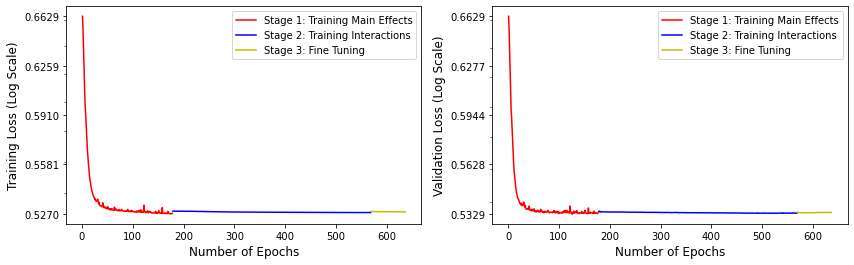

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


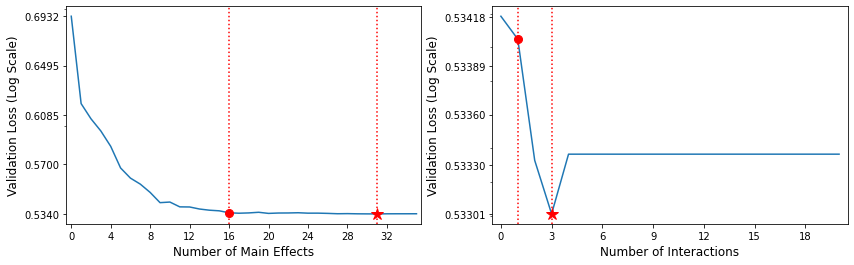

In [6]:
folder = "./results/"
if not os.path.exists(folder):
    os.makedirs(folder)


model_fico = GAMINet(meta_info={"X" + str(i + 1):item for i, item in enumerate(meta_info.values())}, interact_num=20,
            interact_arch=[40] * 5, subnet_arch=[40] * 5, 
            batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, 
            lr_bp=[0.001, 0.001, 0.0001], early_stop_thres=[50, 50, 50],
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            mono_increasing_list=[0, 1, 2, 3, 4, 7, 8, 9, 10, 14],
            mono_decreasing_list=[5, 6, 12, 15, 16, 17, 18, 21],
            verbose=True, val_ratio=0.2, random_state=0)
model_fico.fit(train_x, train_y)
data_dict_logs = model_fico.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="fico_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="fico_regu", save_png=True, save_eps=True)

In [8]:
pred_train = model_fico.predict(train_x)
pred_test = model_fico.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.81342 0.81299]


In [9]:
gaminet_stat = np.hstack([np.round(np.mean(train_y == (pred_train > 0.5)),5),
                          np.round(np.mean(test_y == (pred_test > 0.5)),5)])
print(gaminet_stat)

[0.7462  0.73975]


Global Interpretation

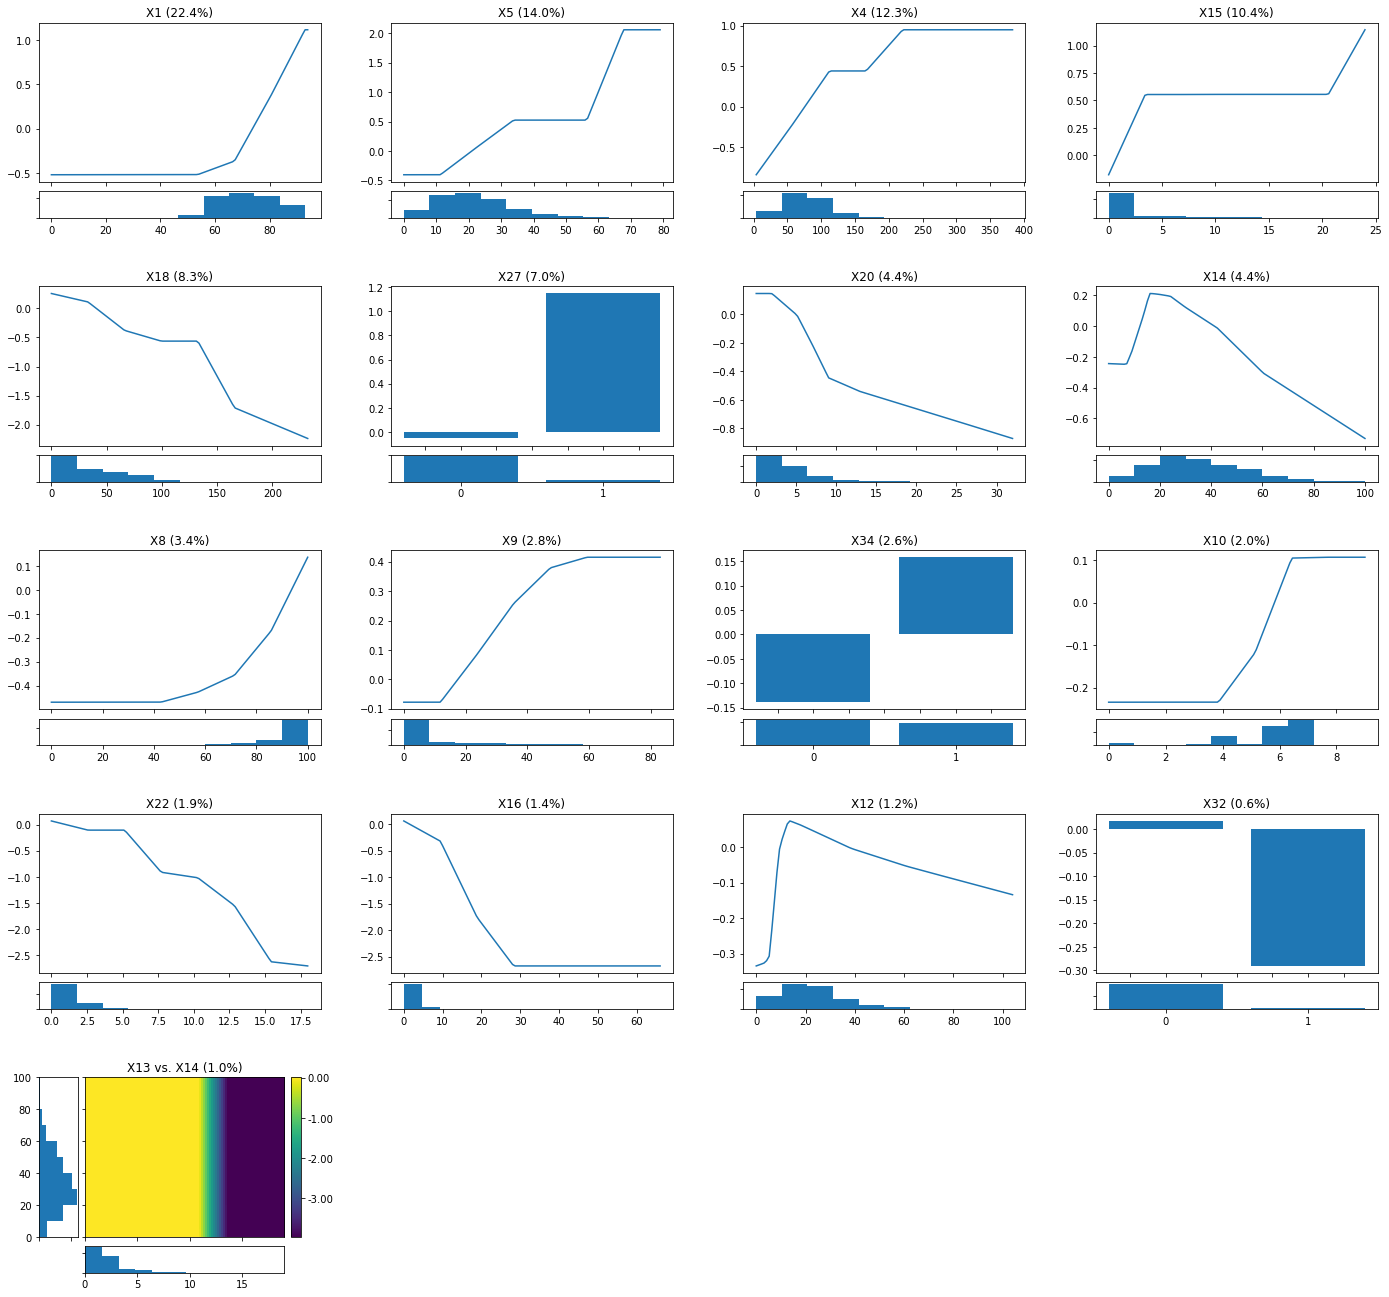

In [10]:
data_dict_global = model_fico.global_explain(save_dict=True, folder=folder, name="fico_global")
global_visualize_density(data_dict_global, folder=folder, name="fico_global",  #11, 13, 19, 20
                         main_effect_num=16, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

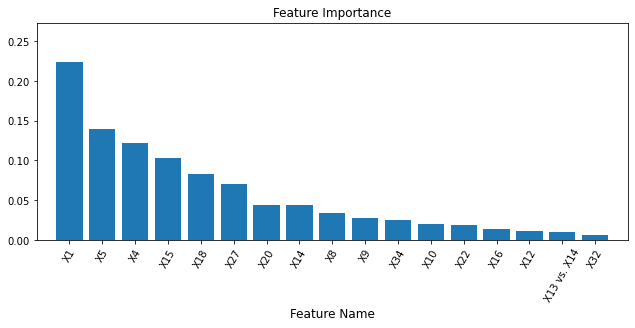

In [11]:
feature_importance_visualize(data_dict_global)

Interpret the prediction of a test sample

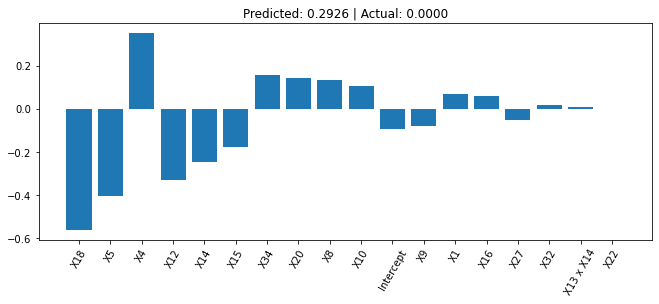

In [12]:
data_dict_local = model_fico.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)